In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op
import sys
sys.path.insert(0, op.dirname(os.getcwd()))

# python libs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]

# tk libs
from lib.objs.tkpaths import Site
from lib.io.matlab import ReadNakajoMats
from lib.util.operations import GetUniqueRows
from lib.tcyclone import Extract_Circle_Nakajo, SortCategoryCount


# --------------------------------------
# Site paths and parameters
site = Site('KWAJALEIN')

DB = site.pc.DB                        # common database
ST = site.pc.site                      # site database
PR = site.params                       # site parameters

# input files
p_nakajo_mats = DB.TCs.nakajo_mats

# output files
p_probs_synth = ST.TCs.probs_synth

# wave point lon, lat, and radius for TC selection
pnt_lon = float(PR.WAVES.point_longitude)
pnt_lat = float(PR.WAVES.point_latitude)
r1 = float(PR.TCS.r1)                   # bigger one
r2 = float(PR.TCS.r2)                   # smaller one


In [2]:
# --------------------------------------
# read each nakajo simulation pack from .mat custom files 
xds_Nakajo = ReadNakajoMats(p_nakajo_mats)

# dictionary with needed variable names
d_vns = {
    'longitude':'ylon_TC',
    'latitude':'ylat_TC',
    'pressure':'yCPRES',
}


# Extract synthetic TCs at 2 radius to get category change 
print(
'\nExtracting Synthetic TCs from Nakajo database...\n \
Lon = {0:.2f}º , Lat = {1:.2f}º\n \
R1  = {2:6.2f}º , R2  = {3:6.2f}º'.format(
    pnt_lon, pnt_lat, r1, r2)
)

# Extract TCs inside R=14 and positions
_, xds_in_r1 = Extract_Circle_Nakajo(
    xds_Nakajo, pnt_lon, pnt_lat, r1, d_vns)

# Extract TCs inside R=4 and positions
_, xds_in_r2 = Extract_Circle_Nakajo(
    xds_Nakajo, pnt_lon, pnt_lat, r2, d_vns)

print xds_in_r1
print ''
print xds_in_r2


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The inplace argument has been deprecated and will be removed in xarray 0.12.0.
  # This is added back by InteractiveShellApp.init_path()



Extracting Synthetic TCs from Nakajo database...
 Lon = 167.50º , Lat = 9.75º
 R1  =  14.00º , R2  =   4.00º


/usr/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<xarray.Dataset>
Dimensions:              (storm: 61898)
Coordinates:
  * storm                (storm) int64 5 8 14 50 ... 999974 999982 999986 999990
Data variables:
    category             (storm) int64 1 4 2 2 1 0 0 0 1 5 ... 1 2 1 1 4 0 2 2 1
    inside_pressure_min  (storm) float64 983.2 932.8 965.7 ... 968.4 975.2 992.4
    inside_pos           (storm) object [61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84
 85 86] ... [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
    inside_pressure      (storm) object [991.98583 991.81708 991.41019 990.96488 990.61428 990.41208 990.09207
 989.73297 989.71549 989.4566  989.51435 989.22639 988.65958 988.79692
 988.61231 988.16172 988.14866 987.9042  987.85809 987.54766 986.45411
 986.06667 985.17192 984.62584 983.67912 983.23432] ... [1007.5     1007.22777 1006.14697 1004.80279 1003.26299 1002.80732
 1000.48049  998.02579  997.22962  996.52729  995.96678  996.13626
  995.89496  996.85364  996.83482  996.48428  9

In [3]:
print('\nCalculating Syntethic TCs category-change probabilities...')

# Get min pressure and storm category inside both circles
n_storms = len(xds_in_r1.storm)
categ_r1r2 = np.empty((n_storms, 2))
for i in range(len(xds_in_r1.storm)):

    # min pressure inside R1
    storm_in_r1 = xds_in_r1.isel(storm=[i])
    storm_id = storm_in_r1.storm.values[0]
    storm_cat_r1 = storm_in_r1.category

    # min pressure inside R2
    if storm_id in xds_in_r2.storm.values[:]:
        storm_in_r2 = xds_in_r2.sel(storm=[storm_id])
        storm_cat_r2 = storm_in_r2.category
    else:
        storm_cat_r2 = 9  # no category 

    # store categories
    categ_r1r2[i,:] = [storm_cat_r1, storm_cat_r2]


# count category changes and sort it
categ_count = GetUniqueRows(categ_r1r2)
categ_count = SortCategoryCount(categ_count)

# calculate probability
m_count = np.reshape(categ_count[:,2], (6,-1)).T
m_sum = np.sum(m_count,axis=0)

probs = m_count.astype(float)/m_sum.astype(float)
probs_cs = np.cumsum(probs, axis=0)

# store output using xarray
xds_categ_cp = xr.Dataset(
    {
        'category_change_count': (('category','category'), m_count[:-1,:]),
        'category_change_sum': (('category'), m_count[-1,:]),
        'category_change_probs': (('category','category'), probs[:-1,:]),
        'category_nochange_probs': (('category'), probs[-1,:]),
        'category_change_cumsum': (('category','category'), probs_cs[:-1,:]),
    },
    coords = {
        'category': [0,1,2,3,4,5]
    }
)
xds_categ_cp.to_netcdf(p_probs_synth)
print xds_categ_cp
print('\nSyntethic TCs category-change stored at:\n{0}'.format(p_probs_synth))



Calculating Syntethic TCs category-change probabilities...
<xarray.Dataset>
Dimensions:                  (category: 6)
Coordinates:
  * category                 (category) int64 0 1 2 3 4 5
Data variables:
    category_change_sum      (category) int64 19762 18114 3676 4090 1740 1767
    category_change_count    (category, category) int64 1809 1288 273 ... 0 985
    category_change_probs    (category, category) float64 0.08386 ... 0.252
    category_nochange_probs  (category) float64 0.9161 0.8766 ... 0.4258 0.4521
    category_change_cumsum   (category, category) float64 0.08386 ... 0.5479

Syntethic TCs category-change stored at:
/Users/ripollcab/Projects/TESLA-kit/source/teslakit/data/sites/KWAJALEIN/TCs/TCs_synth_ProbsChange.nc


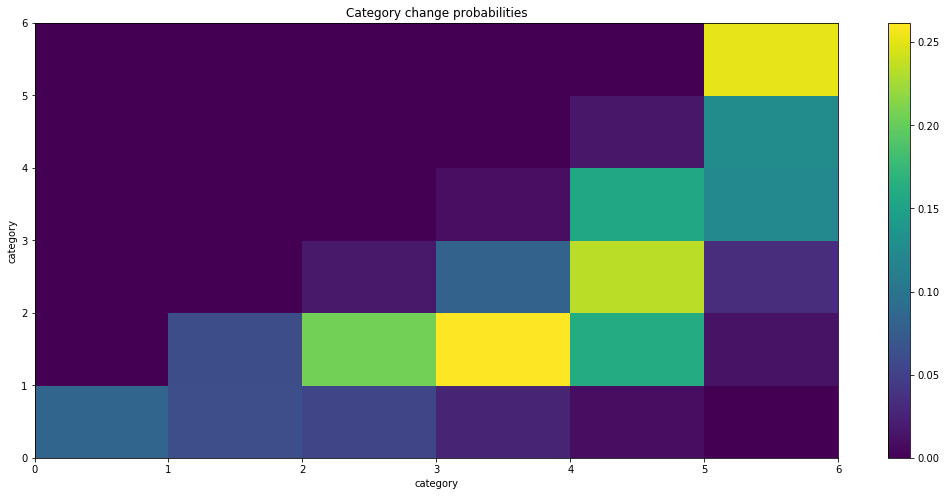

In [31]:
# plot category change probabilities
cp = xds_categ_cp.category_change_probs.values[:]
cs = xds_categ_cp.category.values[:]

fig, axes = plt.subplots()
axes.set_title('Category change probabilities')
axes.set_xlabel('category')
axes.set_ylabel('category')
pc=axes.pcolor(cp)
fig.colorbar(pc)

plt.show()
